<h2> Introduction </h2>

In this kernel, we will use Gausian Process Regressions and Bayesian Optimisation on ecoacoustic metrics to quantify the spatiotemporal distribution of birds on-farm. The data was obtained by placing 20 audio recorders across the property in a grid formation. The biodiversity project was set up in 14 and 15th Nov 2019.


<h2> Our Goals </h2>

<ul>
<li> Understand the spatial and temporal variability in the data, in particular, study how avian species richness change, examine if there are seasonal cycles.
<li> Determine the optimal placement of the 20 audio recorders using the previously described methods. </li>
<li> Determine what the optimal placement would be if one or more of the recorders were to stop functioning. </li>
</ul>


<h2> Outline </h2>

I. <b>Our Toolbox</b><br>
a) [The PreProcessing Class](#preprocessingclass)<br>
b) [The EcouacousticModel Class](#ecoacousticmodelclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(i) [The SingleFrameGaussianProcessModel Class](#singlegpclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(ii) [The FullGaussianProcessModel Class](#fullgpclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(iii) [The SVDModel Class](#svdmodel)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(iv) [The SiteSelection Class](#siteselection)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(v) [The TSModel Class](#tsmodelclass)<br>
e) [The Visualise Class](#visualiseclass)<br>

II. <b>Understanding our data</b><br>
b) [Initializing and pre-processing our data](#initializing)<br>
b) [Gathering sense of our data](#gather)<br>


III. <b>Gaussian Process Regression spatiotemporal predictions</b><br>
a) [Picture: single timeframe spatial gaussian process regression predictions](#singlegp)<br>
b) [Video: spatiotemporal gaussian process regression predictions over the whole timeframe](#fullgp)<br>


IV. <b>Understanding the spatial and temporal variability in avian richness</b><br>
a) [Timeseries analysis](#tsmodel)<br>
b) [Spatiotemporal analysis?](#spatiotemporal)<br>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import statsmodels.api as sm
from itertools import product
import datetime as dt
from os.path import exists

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import warnings
# warnings.filterwarnings("ignore")

<h2> I. Our Toolbox </h2>
<a id="preprocessingclass"></a>

<h3>a) The PreProcessing Class</h3>

-Explanation here-

In [2]:
class PreProcessing:
    def __init__(self,data_name,metadata_name,data_type):
        self.instrument_data = pd.read_csv(data_name)
        self.instrument_metadata = pd.read_csv(metadata_name)
        self.names = np.unique(self.instrument_data['name'])
        self.formatted_data = self.format_data(data_type)
        self.current_data = self.formatted_data
        self.get_metadata()
        
    def get_metadata(self):
        metadata = self.instrument_metadata.set_index('instrument_name').sort_index()
        self.current_metadata = metadata.loc[self.names]
        return self.current_metadata
        
    def get_names(self):
        return list(self.current_data.columns)
    
    def get_single_frame_data(self,data,index):        
        data = data.iloc[index]
        lats,longs = [],[]
        for name in self.names:
            lats.append(self.current_metadata['latitude'][name])
            longs.append(self.current_metadata['longitude'][name])

        single_frame_data = pd.DataFrame({'long':longs,'lat':lats,'val':data.values})
        
        return single_frame_data
    
    def get_data_for_full_gp(self,data,av_each_date = True):
        
        lats, longs, times,vals = [],[],[],[]
        
        for name in self.names:
            for time in data[name].index:
                lats.append(self.current_metadata['latitude'][name])
                longs.append(self.current_metadata['longitude'][name])
                times.append(time)
                vals.append(data[name][time])
                
        data_for_gp = pd.DataFrame({'long':longs,'lat':lats,'time':times,'val':vals})
        
        if av_each_date:
            data_for_gp['time'] = data_for_gp.time.apply(lambda x: dt.datetime.timestamp(dt.datetime(x.year,x.month,x.day)))
        else:
            data_for_gp['time'] = data_for_gp.time.apply(lambda x: dt.datetime.timestamp(dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')))

        return data_for_gp
    
    def get_single_site_data(self,data,name):
        return data[name]
        
    def format_data(self,data_type):
        diversity_index = self.instrument_data[self.instrument_data['type']==data_type]
        self.all_times = np.unique(diversity_index['timeStart'])
        
        grouped = diversity_index.groupby(['timeStart','name'], as_index=False).sum()
        grouped = grouped.drop('instrument_id', axis=1)
        pivoted = grouped.pivot(index="timeStart", columns="name").reset_index(drop=True)
        formatted_data = pivoted.droplevel(level=0, axis=1)
        formatted_data.columns.name = None
        formatted_data.fillna(0, inplace=True)

        return formatted_data
    
    def remove_plot(self):
#         This could be improved upon by looking at the intersections
        max_num_zeros = 0
        name_max_num_zeros = ''
        for name in self.names:
            num_zeros = (self.current_data[name]==0).sum()
            if num_zeros > max_num_zeros:
                max_num_zeros = num_zeros
                name_max_num_zeros = name
        self.current_data = self.current_data.drop(columns = [name_max_num_zeros])
        self.names = self.get_names()
        
    def get_sections(self,current_data,name):
        bool_zeros = current_data[:][name].values==0
        toggle = 2
        toggle_array=[]
        non_zero_sections = []
        zero_sections = []
        for i in range(bool_zeros.size):
            if toggle!=bool_zeros[i]:
                toggle = bool_zeros[i]
                toggle_array.append(i)
                if toggle and len(toggle_array)>1:
                    non_zero_sections.append([toggle_array[-2],i])
                elif not toggle and len(toggle_array)>2:
                    zero_sections.append([toggle_array[-2],toggle_array[-1]])
            if i == bool_zeros.size-1:
                if toggle:
                    zero_sections.append([toggle_array[-1],i])
                else:
                    non_zero_sections.append([toggle_array[-1],i])

        return non_zero_sections,zero_sections

    def get_overlapping_intersections(self,current_data):
        all_non_zero_sections = []
        for name in self.names:
            _,zero_sections = self.get_sections(current_data,name)
            for i in range(len(zero_sections)):
                len_section = zero_sections[i][1]-zero_sections[i][0] + 1
                if len_section < 20:
                    self.current_data[name][zero_sections[i][0]:zero_sections[i][1]] = np.nan

            non_zero_sections,_ = self.get_sections(current_data,name)
            all_non_zero_sections.append(non_zero_sections)           
        intersections = self.get_intersections(all_non_zero_sections)
        return intersections

    def get_intersection(self,range_1,range_2):
        x = range(range_1[0],range_1[1])
        y = range(range_2[0],range_2[1])
        xs = set(x)
        inter = xs.intersection(y)
        if len(inter) == 0:
            return []
        return [min(list(inter)),max(list(inter))+1]

    def get_intersections(self,all_non_zero_sections):
        final_set = []
        for i in range(len(all_non_zero_sections[0])):
            base_set = [all_non_zero_sections[0][i]]
            if len(all_non_zero_sections)>1:
                for j in range(1,len(all_non_zero_sections)):
                    new_set = []
                    # Loop over values in base_set
                    for k in range(len(base_set)):
                        # Loop over values in each section
                        for l in range(len(all_non_zero_sections[j])):
                            inter = self.get_intersection(base_set[k],all_non_zero_sections[j][l])
                            if len(inter) != 0:
                                new_set.append(inter)
                    base_set = new_set
            for b_set in base_set:
                final_set.append(b_set)
        return final_set
    
    def get_current_cleaned_data(self):
        ranges = self.get_overlapping_intersections(self.current_data)
        diff_r = []
        for r in ranges:
            diff_r.append(r[1]-r[0])
        max_range_idx = np.argmax(diff_r)
        cleaned_data = self.current_data.iloc[ranges[max_range_idx][0]:ranges[max_range_idx][1]]
        cleaned_and_interpolated_data = self.interpolate_data(cleaned_data)
        self.current_cleaned_data = cleaned_data
        
        cleaned_data['time'] = self.all_times[ranges[max_range_idx][0]:ranges[max_range_idx][1]]
        cleaned_data = cleaned_data.set_index('time')

        return cleaned_data
    
    def interpolate_data(self,data):
        for name in self.names:
            data[name] = data[name].interpolate()
        return data
    
    def get_current_cleaned_date_data(self,df):
        df = df.reset_index()
        df['time'] = df['time'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
        df['time'] = df.time.dt.date
        self.current_cleaned_date_data = df.groupby('time', as_index=False).mean().set_index('time')
        return self.current_cleaned_date_data
    
    def get_av_period(self,df):
        df = df.reset_index()
        df['time'] = df['time'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
        df['time'] = df.time.dt.date
        df = df.groupby('time', as_index=False).count()
        df = df['A01']
        return int(np.round(np.mean(df.values),0))

<a id="ecoacousticmodelclass"></a>

<h3>b) The EcoacousticModel class</h3>

-Explanation here-

In [3]:
class EcoacousticModel:
    def __init__(self):
        print('Initializing Model')
        
    def save_results(self,fig_anim,filename,animation=False):
        if exists(filename):
            print('This file already exists')
        else:
            if animation:
                fig_anim.save(filename)
            else:
                fig_anim.savefig(filename)

<a id="singlegpclass"></a>

<h4>b) (i) The SingleFrameGaussianProcessModel class</h4>

-Explanation here-

In [4]:
class SingleFrameGaussianProcessModel(EcoacousticModel):   
    def __init__(self,title):
        super().__init__()

        # Input space
        kernel = RBF([1,1], (1e-2, 1e-2))
        self.gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
        
        self.title = ("_".join(str(title).split())).replace(':','')
        self.path = 'results/GPs/single_frames/'
        
        self.trained = False


    def train(self,X,y):
        self.gp.fit(X, y)
        self.X, self.y = X, y
        self.filename = self.path + 'single_frame_gp_'+str(X.shape[0])+'_stations_at_'+self.title +'.png'
        self.trained = True
        
    def predict(self, x1x2, plot = False):
        if self.trained:
            
            n_points = int(np.sqrt(x1x2.shape[0]))
            X0p, X1p = x1x2[:,0].reshape(n_points,n_points), x1x2[:,1].reshape(n_points,n_points)

            y_pred, MSE = self.gp.predict(x1x2, return_std=True)
            y_lower = y_pred - 2*MSE
            y_higher = y_pred + 2*MSE

            if plot: 
                Zp_mean = np.reshape(y_pred,(n_points,n_points))
                Zp_lower = np.reshape(y_lower,(n_points,n_points))
                Zp_higher = np.reshape(y_higher,(n_points,n_points))

                vmin = np.min(y_lower)
                vmax = np.max(y_higher)

                fig, ax = plt.subplots(1,4,figsize=(20,4),gridspec_kw={"width_ratios":[1,1,1,0.05]})

                pred_plot = ax[1].pcolormesh(X0p, X1p, Zp_mean,vmin=vmin,vmax=vmax,cmap='RdBu_r',shading='auto')
                ax[1].scatter(self.X[:,0],self.X[:,1],s = self.y*100,c='g')
                ax[1].title.set_text('μ')
                ax[1].set_xlabel('Longitude')
                ax[1].set_ylabel('Latitude')

                ax[0].pcolormesh(X0p, X1p, Zp_lower,vmin=vmin,vmax=vmax,cmap='RdBu_r',shading='auto')
                ax[0].scatter(self.X[:,0],self.X[:,1],s = self.y*100,c='g')
                ax[0].title.set_text('-2σ')
                ax[0].set_xlabel('Longitude')
                ax[0].set_ylabel('Latitude')

                ax[2].pcolormesh(X0p, X1p, Zp_higher,vmin=vmin,vmax=vmax,cmap='RdBu_r',shading='auto')
                ax[2].scatter(self.X[:,0],self.X[:,1],s = self.y*100,c='g')
                ax[2].title.set_text('+2σ')
                ax[2].set_xlabel('Longitude')
                ax[2].set_ylabel('Latitude')

                fig.colorbar(pred_plot, cax=ax[3])
                fig.suptitle(str(self.title))

                self.save_results(fig,self.filename)
                plt.show()

            return y_pred, y_lower, y_higher
        else:
            print('Train the model first!')

<a id="fullgpclass"></a>

<h4>b) (ii) The FullGaussianProcessModel class</h4>

-Explanation here-

In [5]:
class FullGaussianProcessModel(EcoacousticModel): 
#         filename = 
    def __init__(self):
        super().__init__()
        self.path = 'results/GPs/full_gp/'
        self.trained = False
        self.gp = GaussianProcessRegressor(n_restarts_optimizer=15)
        
    def train(self, X, y):
        self.filename = self.path + 'full_gp_'+str(data_for_gp.long.unique().size)+'_stations.gif'
        self.filename_MSE = self.path + 'full_gp_'+str(data_for_gp.long.unique().size)+'_stations_MSE.gif'
        self.X = X
        self.y = y
        self.gp.fit(X, y)
        self.trained = True

    def predict(self, x1x2x3, plot = False):
        if self.trained:
            y_pred, MSE = self.gp.predict(x1x2x3, return_std=True)

            y_lower = y_pred - 2*MSE
            y_higher = y_pred + 2*MSE

            self.vmin = np.min(y_lower)
            self.vmax = np.max(y_higher)

            self.vmin_MSE = np.min(MSE)
            self.vmax_MSE = np.max(MSE)
            
            raw_data = pd.DataFrame({'long':self.X[:,0],'lat':self.X[:,1],'time':self.X[:,2],'val':self.y}).set_index(['long','lat','time'])
            wide_raw_data =  raw_data.pivot_table(values=['val'], index= ['long','lat'],columns='time')
            wide_raw_data = wide_raw_data.droplevel(level=0, axis=1)
            wide_raw_data.columns.name = None
                        
            pred_df = pd.DataFrame({'y_pred':y_pred,'y_lower':y_lower,'y_higher':y_higher,'MSE':MSE})
            cov_df = pd.DataFrame({'long':x1x2x3[:,0],'lat':x1x2x3[:,1],'time':x1x2x3[:,2]})

            df = pd.concat([pred_df, cov_df], axis=1)

            wide_ypred =  df.pivot_table(values=['y_pred'], index= ['long','lat'],columns='time')
            wide_ypred = wide_ypred.droplevel(level=0, axis=1)
            wide_ypred.columns.name = None

            wide_ylower =  df.pivot_table(values=['y_lower'], index= ['long','lat'],columns='time')
            wide_ylower = wide_ylower.droplevel(level=0, axis=1)
            wide_ylower.columns.name = None

            wide_yhigher =  df.pivot_table(values=['y_higher'], index= ['long','lat'],columns='time')
            wide_yhigher = wide_yhigher.droplevel(level=0, axis=1)
            wide_yhigher.columns.name = None

            wide_MSE =  df.pivot_table(values=['MSE'], index= ['long','lat'],columns='time')
            wide_MSE = wide_MSE.droplevel(level=0, axis=1)
            wide_MSE.columns.name = None

            if plot:
                self.create_animation(wide_ypred, wide_ylower, wide_yhigher, wide_MSE, wide_raw_data)

            return wide_ypred, wide_ylower, wide_yhigher
        else:
            print('Train the model first!')
        
    def create_animation(self,pred,lower,higher,MSE, raw_data):
        long_lats = np.array([list(item) for item in pred.index])
        raw_long_lats = np.array([list(item) for item in raw_data.index])

        n_points = int(np.sqrt(long_lats[:,0].size))
        X0, X1 = long_lats[:,0].reshape(n_points,n_points), long_lats[:,1].reshape(n_points,n_points)

        def format_title(datetime):
            return str(dt.datetime.fromtimestamp(int(np.round(datetime,0))).date())
        
        fig1, ax1 = plt.subplots(1,4,figsize=(20,4),gridspec_kw={"width_ratios":[1,1,1,0.05]})
        fig1.subplots_adjust(wspace=0.3)

        ax1[0].title.set_text('-2σ')
        ax1[0].set_xlabel('Longitude')
        ax1[0].set_ylabel('Latitude') 
        
        ax1[1].title.set_text('μ')
        ax1[1].set_xlabel('Longitude')
        ax1[1].set_ylabel('Latitude')        

        ax1[2].title.set_text('-2σ')
        ax1[2].set_xlabel('Longitude')
        ax1[2].set_ylabel('Latitude') 
        
        lower_plot = ax1[0].pcolormesh(X0, X1, np.reshape(lower[lower.columns[0]].values,(n_points,n_points)),vmin=self.vmin,vmax=self.vmax,cmap='RdBu_r',shading='auto')
        lower_plot_scatter = ax1[0].scatter(raw_long_lats[:,0], raw_long_lats[:,1], s = raw_data[raw_data.columns[0]].values*100,c='g')

        pred_plot = ax1[1].pcolormesh(X0, X1, np.reshape(pred[pred.columns[0]].values,(n_points,n_points)),vmin=self.vmin,vmax=self.vmax,cmap='RdBu_r',shading='auto')
        pred_plot_scatter = ax1[1].scatter(raw_long_lats[:,0], raw_long_lats[:,1], s = raw_data[raw_data.columns[0]].values*100,c='g')
        
        higher_plot = ax1[2].pcolormesh(X0, X1, np.reshape(higher[higher.columns[0]].values,(n_points,n_points)),vmin=self.vmin,vmax=self.vmax,cmap='RdBu_r',shading='auto')
        higher_plot_scatter = ax1[2].scatter(raw_long_lats[:,0], raw_long_lats[:,1], s = raw_data[raw_data.columns[0]].values*100,c='g')
        
        fig1.colorbar(pred_plot, cax=ax1[3])
        
        title_1 = fig1.suptitle(format_title(pred.columns[0]))
        
        def animate(i):
            lower_plot.set_array(np.reshape(lower[lower.columns[i+1]].values,(n_points,n_points)).flatten())
            lower_plot_scatter.set_sizes(raw_data[raw_data.columns[i+1]].values*100)
            
            pred_plot.set_array(np.reshape(pred[pred.columns[i+1]].values,(n_points,n_points)).flatten())
            pred_plot_scatter.set_sizes(raw_data[raw_data.columns[i+1]].values*100)

            higher_plot.set_array(np.reshape(higher[higher.columns[i+1]].values,(n_points,n_points)).flatten())
            pred_plot_scatter.set_sizes(raw_data[raw_data.columns[i+1]].values*100)
            
            title_1.set_text(format_title(pred.columns[i+1]))
            return lower_plot,pred_plot,higher_plot
        
        anim = FuncAnimation(fig1, animate, interval=500, frames=pred.shape[1] - 1,blit=False)
        self.save_results(anim,self.filename,True)
        
        
        fig2, ax2 = plt.subplots()  
        ax2.title.set_text('MSE')
        ax2.set_xlabel('Longitude')
        ax2.set_ylabel('Latitude')
        
        MSE_plot = ax2.pcolormesh(X0, X1, np.reshape(MSE[MSE.columns[0]].values,(n_points,n_points)),vmin=self.vmin_MSE,vmax=self.vmax_MSE,cmap='RdBu_r',shading='auto')        
        title_2 = fig2.suptitle(format_title(MSE.columns[0]))
        fig2.colorbar(MSE_plot)

        def animate_MSE(i):
            MSE_plot.set_array(np.reshape(MSE[MSE.columns[i+1]].values,(n_points,n_points)).flatten())
            title_2.set_text(format_title(MSE.columns[i+1]))
            return MSE_plot
        
        anim_MSE = FuncAnimation(fig2, animate_MSE, interval=500, frames=MSE.shape[1] - 1)
        self.save_results(anim_MSE,self.filename_MSE,True)

<a id="svdmodelclass"></a>

<h4>b) (iii) The SVDModel class</h4>

-Explanation here-

Will be used to visualise modes of the full Gaussian process

In [6]:
class SVDModel(EcoacousticModel): 
    def __init__(self, data_from_full_gp,num_sites,data_type):
        super().__init__()
        self.num_sites = num_sites
        self.data_type = data_type
        self.eof, d, u = np.linalg.svd(data_from_full_gp)
        self.path = 'results/GPs/full_gp/EOFs/'
        long_lats = np.array([list(item) for item in data_from_full_gp.index])
        n_points = int(np.sqrt(long_lats[:,0].size))
        self.X0, self.X1 = long_lats[:,0].reshape(n_points,n_points), long_lats[:,1].reshape(n_points,n_points)
        
    def show_EOF(self,resolution,eof_number):
        suf = lambda n: "%d%s"%(n,{1:"st",2:"nd",3:"rd"}.get(n if n<20 else n%10,"th"))
        self.filename = self.path + 'EOF_number_' + suf(eof_number) + '_from_GP_'+ self.data_type +'_data_with_' + str(self.num_sites) + '_sites.png'
        index = 0
        formatted_eof = np.zeros((resolution,resolution))
        for i in range(formatted_eof.shape[0]):
            for j in range(formatted_eof.shape[1]):
                formatted_eof[i,j] = self.eof[index,eof_number-1]
                index+=1
        
        fig, ax = plt.subplots()  
        eof_plot = ax.pcolor(self.X0, self.X1, formatted_eof,cmap='RdBu_r')
        ax.title.set_text('Colour Map of the '+suf(eof_number)+' EOF')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        fig.colorbar(eof_plot)

        self.save_results(fig,self.filename)
        
        plt.show()

<a id="siteselectionclass"></a>

<h4>b) (iv) The SiteSelection class</h4>

-Explanation here-

In [ ]:
class SiteSelection(EcoacousticModel): 
    def __init__(self, data_from_full_gp,num_sites,data_type):
        super().__init__()
        

# Testing

In [7]:
preprocessor = PreProcessing('data/instrument_data.csv','data/instrument_metadata.csv','ADI')
preprocessor.remove_plot()
metadata = preprocessor.get_metadata()
ecoacoustic_data = preprocessor.get_current_cleaned_data()
ecoacoustic_date_data = preprocessor.get_current_cleaned_date_data(ecoacoustic_data)
period = preprocessor.get_av_period(ecoacoustic_data)

C:\Users\samue\AppData\Local\Temp/ipykernel_5376/4060044432.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[name] = data[name].interpolate()
C:\Users\samue\AppData\Local\Temp/ipykernel_5376/4060044432.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['time'] = self.all_times[ranges[max_range_idx][0]:ranges[max_range_idx][1]]


In [8]:
# # Prepare data for Full GP
# data_for_gp = preprocessor.get_data_for_full_gp(ecoacoustic_date_data,av_each_date = True)

# # Initialize model
# full_gp_model = FullGaussianProcessModel()

# # Train model
# X = data_for_gp[['long','lat','time']].values
# y = data_for_gp.val.values
# full_gp_model.train(X,y)

# # Predict
# resolution = 50
# x1 = np.linspace(np.min(data_for_gp.long), np.max(data_for_gp.long),resolution) #p
# x2 = np.linspace(np.min(data_for_gp.lat), np.max(data_for_gp.lat),resolution) #q
# x3 = np.linspace(np.min(data_for_gp.time), np.max(data_for_gp.time),data_for_gp.time.unique().size) #q
# x1x2x3 = np.array(list(product(x1, x2, x3)))
# y_pred,y_lower,y_higher = full_gp_model.predict(x1x2x3,True)



<a id="tsmodelclass"></a>

<h4>b) (v) The TSModel class</h4>

-Explanation here-

In [9]:
class TSModel(EcoacousticModel): 
#         filename = 
    def __init__(self, single_site_data, period):
        super().__init__() 
        self.period = period
        
        self.single_site_data = single_site_data
        self.seasonal_decompose(self.single_site_data)
        
    def seasonal_decompose(self,data):
        decomposition = sm.tsa.seasonal_decompose(data.values, model='additive',extrapolate_trend='freq',period=self.period)
        fig = decomposition.plot()
        fig.set_size_inches(14,7)
        plt.show()

<a id="visualiseclass"></a>

<h3>c) The Visualise class</h3>

-Explanation here-

In [10]:
class Visualise:
    def __init__(self,ecoacustic_data,metadata):
        self.ecoacoustic_data = ecoacoustic_data
        self.metadata = metadata
        self.names = list(self.ecoacoustic_data.columns)
        
    def plot_all_ts(self):
        for name in self.names:
            plt.figure(figsize=(15, 3))
            plt.plot(self.ecoacoustic_data[name].values)
            plt.title(name)
            plt.show()
    
    def point_animation(self):    
        fig,ax = plt.subplots()

        lats = []
        longs = []
        for name in self.names:
            lats.append(self.metadata['latitude'][name])
            longs.append(self.metadata['longitude'][name])

        scatter = ax.scatter(longs, lats,s=np.zeros(len(self.names)))

        def init():
            scatter.set_sizes(np.zeros(len(self.names)))
            return scatter

        def update(frame):
            data = frame
            scatter.set_sizes(data*100)
            return scatter

        anim = FuncAnimation(fig, update, interval=1,frames = self.ecoacoustic_data.values,init_func=init)
        
        filename = 'results/raw_data/station_animations/animation_of_' + str(len(self.names)) + '_plots.gif'
        anim.save(filename)

<h2> II. Understanding our data </h2>

<a id="initializing"></a>

<h3>a) Initializing and pre-processing our data</h3>

-Explanation here

In [11]:
preprocessor = PreProcessing('data/instrument_data.csv','data/instrument_metadata.csv','ADI')
preprocessor.remove_plot()
metadata = preprocessor.get_metadata()
ecoacoustic_data = preprocessor.get_current_cleaned_data()
ecoacoustic_date_data = preprocessor.get_current_cleaned_date_data(ecoacoustic_data)
period = preprocessor.get_av_period(ecoacoustic_data)

C:\Users\samue\AppData\Local\Temp/ipykernel_5376/4060044432.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[name] = data[name].interpolate()
C:\Users\samue\AppData\Local\Temp/ipykernel_5376/4060044432.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['time'] = self.all_times[ranges[max_range_idx][0]:ranges[max_range_idx][1]]


<a id="gathering"></a>

<h3>b) Gathering sense of our data</h3>

-Explanation here-

<h2> III. Gaussian Process Regression spatiotemporal predictions </h2>

<a id="singlegp"></a>

<h3>a) Picture: single timeframe spatial gaussian process regression predictions</h3>

-Explanation here-


C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Initializing Model
This file already exists


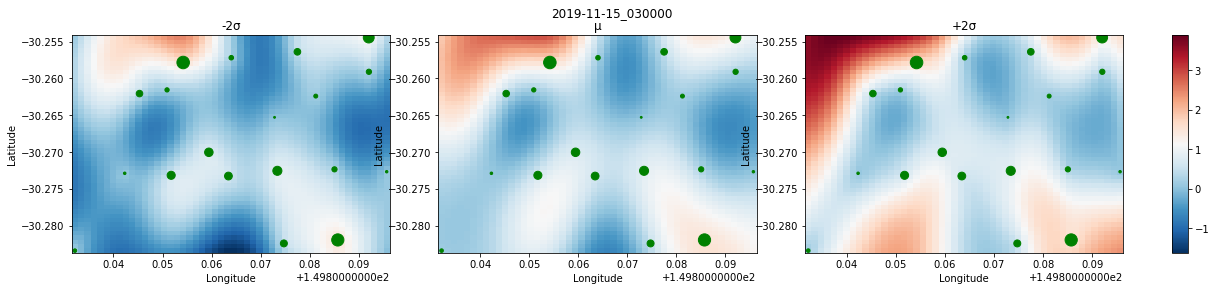

Initializing Model
This file already exists


C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


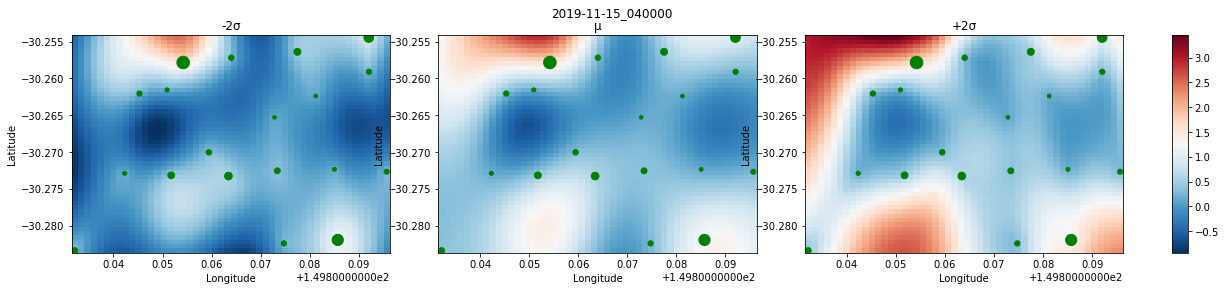

Initializing Model
This file already exists


C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


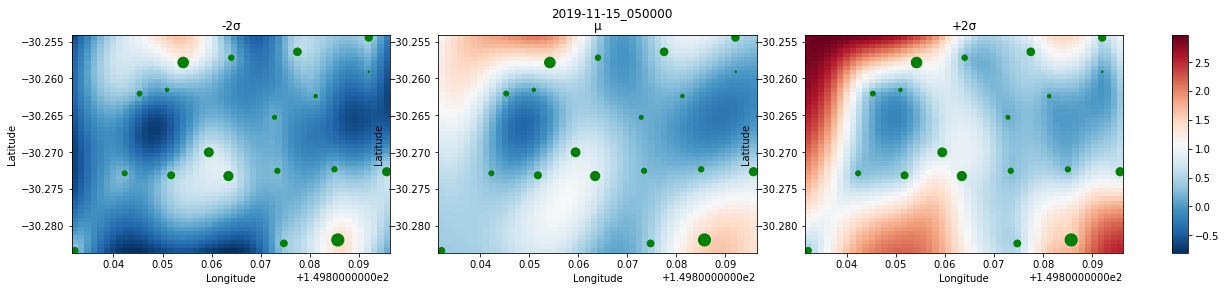

Initializing Model
This file already exists


C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


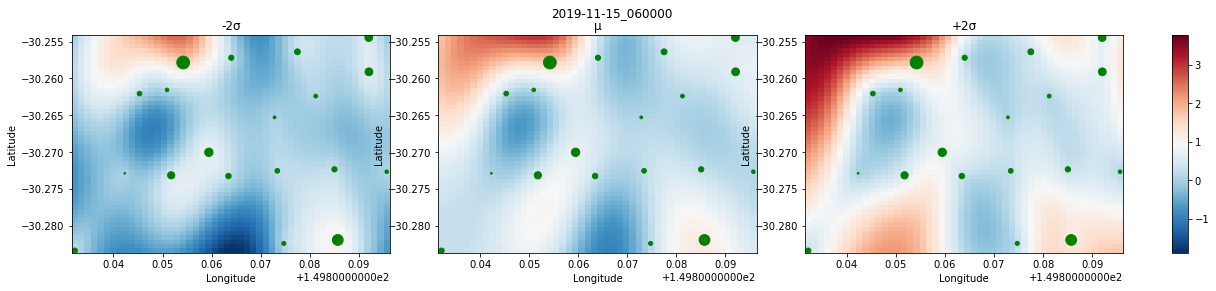

Initializing Model
This file already exists


C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


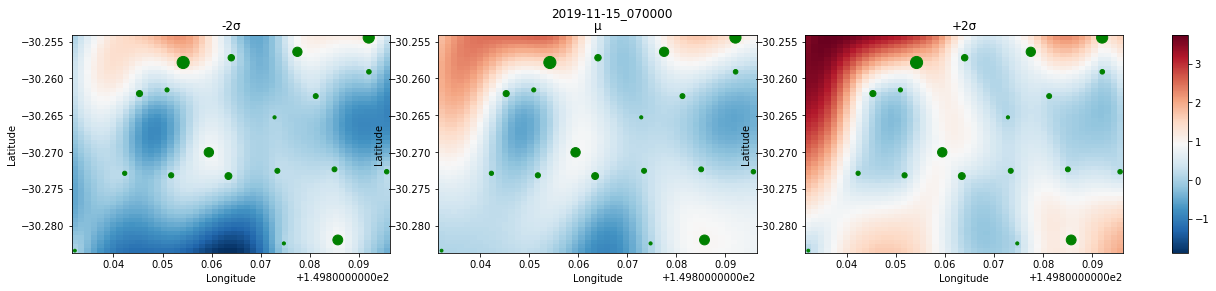

In [12]:
resolution = 50
for i in range(5):
    single_frame_data = preprocessor.get_single_frame_data(ecoacoustic_data,i)
    X_train = single_frame_data[['long','lat']].values
    y_train = single_frame_data.val.values
    
    single_frame_gp_model = SingleFrameGaussianProcessModel(title = ecoacoustic_data.index[i])
    single_frame_gp_model.train(X_train,y_train)
    
    x1 = np.linspace(np.min(single_frame_data.long), np.max(single_frame_data.long),resolution) #p
    x2 = np.linspace(np.min(single_frame_data.lat), np.max(single_frame_data.lat),resolution) #q
    x1x2 = np.array(list(product(x1, x2)))
    y_pred,y_lower,y_higher = single_frame_gp_model.predict(x1x2,plot=True)

Initializing Model


MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


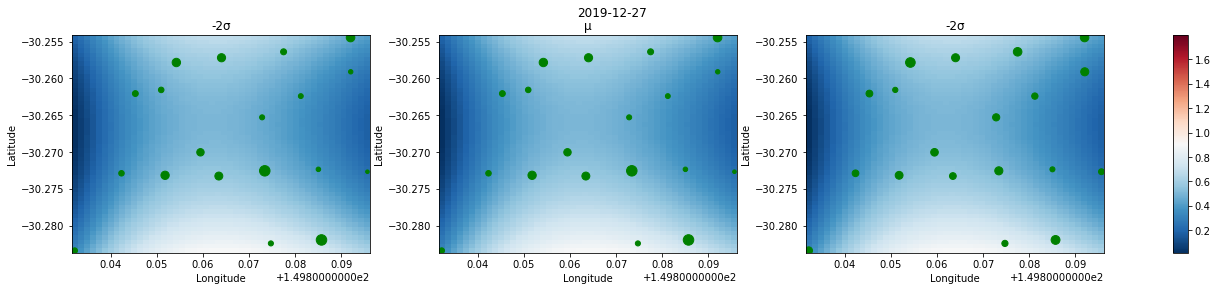

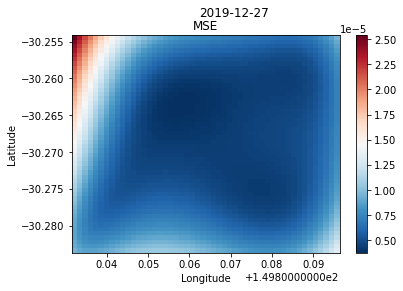

In [13]:
# Prepare data for Full GP
data_for_gp = preprocessor.get_data_for_full_gp(ecoacoustic_date_data,av_each_date = True)

# Initialize model
full_gp_model = FullGaussianProcessModel()

# Train model
X = data_for_gp[['long','lat','time']].values
y = data_for_gp.val.values
full_gp_model.train(X,y)

# Predict
resolution = 50
x1 = np.linspace(np.min(data_for_gp.long), np.max(data_for_gp.long),resolution)
x2 = np.linspace(np.min(data_for_gp.lat), np.max(data_for_gp.lat),resolution)
x3 = np.linspace(np.min(data_for_gp.time), np.max(data_for_gp.time),data_for_gp.time.unique().size)
x1x2x3 = np.array(list(product(x1, x2, x3)))
y_pred,y_lower,y_higher = full_gp_model.predict(x1x2x3,plot = True)

<a id="fullgp"></a>

<h3>a) Video: spatiotemporal gaussian process regression predictions over the whole timeframe</h3>

-Explanation here-

<h2> IV. Understanding the spatial and temporal variability in avian richness </h2>
<a id="tsmodel"></a>

<h3>a) Timeseries analysis </h3>

-Explanation here-

<a id="spatiotemporal"></a>

<h3>a) Spatiotemporal analysis </h3>

-Explanation here-

Initializing Model


C:\Users\samue\AppData\Local\Temp/ipykernel_5376/1715369682.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  eof_plot = ax.pcolor(self.X0, self.X1, formatted_eof,cmap='RdBu_r')


This file already exists


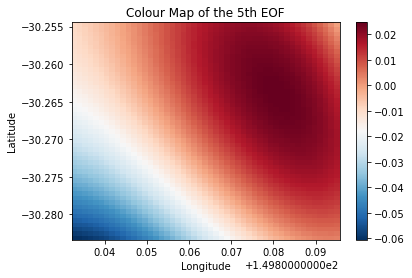

In [14]:
# SVD model
svd_model = SVDModel(y_pred,data_for_gp.long.unique().size,'mean')
svd_model.show_EOF(resolution,5)

In [15]:
# visualiser = Visualise(ecoacoustic_data,metadata)
# visualiser.plot_all_ts()
# visualiser.point_animation()